<a href="https://colab.research.google.com/github/Konstantin-Iakovlev/2021-Optimization_Project/blob/main/SQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Stochastic Quasi Newton methods for Neural Networks 

In [98]:
import numpy as np
from matplotlib import pyplot as plt
import jax.numpy as jnp
from jax import jit, random

In [99]:

class SQN_Optimizer:
    def __init__(self):
        self.M = 10
        self.L = 10
        self.N = 7000
        self.n = 50
        self.w1 = np.random.rand(self.n)
        self.batch_grad_size = 50
        self.batch_hess_size = 300
        # Generate data
        np.random.seed(1)
        self.X = np.random.rand(self.N, self.n)
        self.Y = np.random.rand(self.N)
        # w^k
        self.w_array = [self.w1.copy()]
        # wt
        self.wt_array = []
        # learning rate
        self.beta = 2
        # EMA
        self.mu = 1e-2
        # correction pairs (sj, yj)
        self.corr_pairs = []
        # initialize real F(w1) = Q -- quality
        self.Q_arr = [self.F_maker(np.arange(0, self.N))(self.w1)]
        # precision of Q
        self.eps = 1e-5

    def f(self, w, S):
        # print(type(S), S.shape, type(self.Y), self.Y.shape)
        # print(np.exp(-self.X[S] @ w).shape)
        # return (self.Y[S] - self.X[S] @ w) ** 2
        # print('check: ', self.X[S] @ w)
        return -self.Y[S] * np.log(1/(1 + np.exp(-self.X[S] @ w))) - \
               (1-self.Y[S]) * np.log(1 - 1/(1+np.exp(-self.X[S] @ w))) +\
               0.9 * np.linalg.norm(w) ** 2

    def nabla_F(self, w, S):
        res = np.zeros(w.shape)
        for i in S:
            res += -(1 / (1 + np.exp(-self.X[i] @ w)) - self.Y[i]) * self.X[i]
        return res / self.batch_grad_size + 1.8 * w

    def hess_F(self, w, S, s_arg):
        res = np.zeros(w.shape)
        for i in S:
            # print('Xi w', self.X[i] @ w)
            aux_hess = -1/(1 + np.exp(-self.X[i] @ w))*(1 - 1/(1 + np.exp(-self.X[i] @ w))) * (self.X[i] @ s_arg) * self.X[i]
            res += aux_hess
        return res / self.batch_hess_size + 1.8 * s_arg

    def F_maker(self, S):
        def F(w):
            return (1 / S.shape[0]) * np.sum(self.f(w, S))
        return F


    def Ht(self, t):
        st, yt = self.corr_pairs[-1]
        H = (st @ yt) / (yt @ yt) * np.eye(st.shape[0])
        # print(f'corr pairs len is {len(self.corr_pairs)}')
        # print(f'min = {t, self.M, min(t, self.M)}')
        I = np.eye(st.shape[0])
        for sj, yj in self.corr_pairs[-min(t, self.M):]:
            rhoj = 1 / (yj @ sj)
            # BFGS formula
            H = (I - rhoj*np.outer(sj, yj)) @ H @ (I - rhoj*np.outer(yj, sj)) + rhoj*np.outer(sj, sj)
        # print('Ht', np.linalg.norm(H))
        return H


    def sqn_optimize(self):
        # num of iterations
        iter_num = int(5000)
        t = -1
        self.wt_array.append(np.zeros((self.w1.shape[0],)))
        # print(self.wt_array[-1])
        k = 1 # iteration counter
        while k <= iter_num:
            S = np.random.choice(self.N, size=self.batch_grad_size)
            # dF = grad(self.F_maker(S))
            self.wt_array[-1] += self.w_array[-1]
            if k <= 2 * self.L:
                # print('w_array', self.w_array[-1])
                # print(f'k = {k}')
                self.w_array.append(self.w_array[-1] - (self.beta / k) * self.nabla_F(self.w_array[-1], S))
            else:
                self.w_array.append(self.w_array[-1] -
                            (self.beta/ k) * self.Ht(t) @ self.nabla_F(self.w_array[-1], S))
                # print('w^k', self.w_array[-1])
                # print('dF(wk)', self.nabla_F(self.w_array[-1], S))
                # print(f'k = {k}')
            if k % self.L == 0:
                # print("% == 0")
                t += 1
                self.wt_array[-1] /= self.L
                if t > 0:
                    Sh = np.random.choice(self.N, size=self.batch_hess_size)
                    # hessF = hessian(self.F_maker(Sh))
                    st = self.wt_array[-1] - self.wt_array[-2]
                    yt = self.hess_F(self.wt_array[-1], Sh, st)
                    # print('wt = ', self.wt_array[-1])
                    # print('yt = ', yt)
                    self.corr_pairs.append((st, yt))
                self.wt_array.append(np.zeros((self.w1.shape[0],)))

            self.Q_arr.append(self.mu*self.F_maker(S)(self.w_array[-1]) + (1-self.mu)*self.Q_arr[-1])
            if abs(self.Q_arr[-1] - self.Q_arr[-2]) < self.eps:
                print(f'sqn iterations = {k}')
                break
            k += 1

    def sgd_optimize(self):
        iter_num = int(5000)
        k = 1
        while k <= iter_num:
            S = random.choice(random.PRNGKey(np.random.randint(1)),self.N, shape=(self.batch_grad_size,))
            self.w_array.append(self.w_array[-1] - (self.beta / k)*self.nabla_F(self.w_array[-1], S))
            self.Q_arr.append(self.mu*self.F_maker(S)(self.w_array[-1]) + (1-self.mu)*self.Q_arr[-1])
            if abs(self.Q_arr[-1] - self.Q_arr[-2]) < self.eps:
                print(f'sgd_opt iter = {k}')
                break
            k += 1

    def clear(self):
        self.Q_arr = [self.F_maker(np.arange(0, self.N))(self.w1)]
        self.wt_array = []
        self.w_array = [self.w1]
# TEST
np.random.seed(1)
sqn_opt = SQN_Optimizer()
sqn_opt.sqn_optimize()
print("Ok")



sqn iterations = 656
Ok


sgd_opt iter = 980


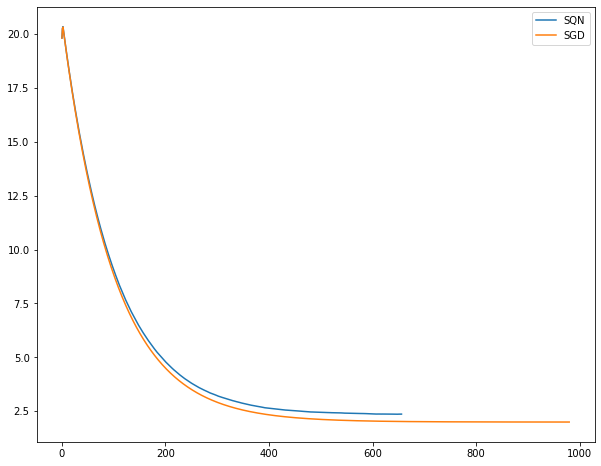

In [100]:
plt.figure(figsize=(10, 8))
plt.plot(sqn_opt.Q_arr, label='SQN')
sqn_opt.clear()
sqn_opt.sgd_optimize()
plt.plot(sqn_opt.Q_arr, label='SGD')
plt.legend()
# print(np.array(sqn_opt.Q_arr))
# print(np.array(sqn_opt.wt_array))

In [33]:
print(np.array([np.linalg.norm(w) for w in sqn_opt.w_array]))

[3.94500638 5.4432822  6.22909548 6.42316951 6.6582369  6.85316773
 6.96810928 7.09960708 7.13216786 7.18485194 7.28514074 7.28827849
 7.35406856 7.39917803 7.42469481 7.44804216 7.46912477 7.51271537
 7.5299597  7.54505331 7.57279528 7.6768868  7.74035926 7.88366394
 8.05836931 8.10031265 8.27578606 8.34701249 8.370324   8.32896235
 8.3323169  8.37386788 8.37087669 8.34439354 8.40297692 8.46699479
 8.44257042 8.47258213 8.55744524 8.57396104 8.61327153 8.59154448
 8.58057788 8.60806579 8.59255844 8.56316187 8.57140215 8.59723093
 8.6235089  8.64695716 8.68454399]


Buffer([1, 1, 2], dtype=int32)